In [7]:
import os

import numpy as np
import h5py
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
from tqdm import tqdm
import matplotlib
import seaborn as sns
sns.set_theme()
import pandas as pd
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.dpi'] = 300

from utils import ECNUM, plot_class_accuracies, plot_confusion

annotations_path = 'data/annotations/merged_anno.txt'
embeddings_path = 'data/ec_vs_NOec_pide100_c50.h5'
val_data_fasta = 'data/nonRed_dataset/ec_vs_NOec_pide20_c50_val.fasta'
test_data_fasta = 'data/nonRed_dataset/ec_vs_NOec_pide20_c50_test.fasta'

In [2]:
val_identifiers = []
for sequence in SeqIO.parse(val_data_fasta, "fasta"):
    val_identifiers.append(sequence.id)

test_identifiers = []
for sequence in SeqIO.parse(test_data_fasta, "fasta"):
    test_identifiers.append(sequence.id)



annotations = {}
for i, annotation in tqdm(enumerate(open(annotations_path))):
        annotation_array = annotation.strip().split('\t')
        identifier = annotation_array[0]
        # ec number is an array with 4 entries. One entry for each component of the ec number
        ec_number = annotation_array[1].split(';')[0].split('.')
        annotations[identifier] = ec_number

253502it [00:00, 316971.70it/s]


In [3]:
val_id_ec = []
val_embeddings_ec = []
val_labels_ec = []
val_id = []
val_embeddings = []
val_labels = []
test_id_ec = []
test_embeddings_ec = []
test_labels_ec = []
test_id = []
test_embeddings = []
test_labels = []
train_id_ec = []
train_embeddings_ec = []
train_labels_ec = []
train_id = []
train_embeddings = []
train_labels = []
with h5py.File(embeddings_path, 'r') as h5:
    h5_keys = h5.keys()
    annotation_ids = annotations.keys()
    val_indices = np.random.randint(0,len(h5_keys),500)
    for id in tqdm(h5_keys):
        embedding = h5[id][:]
        if id in val_identifiers:
            if id in annotation_ids:
                val_embeddings_ec.append(embedding)
                val_labels_ec.append(annotations[id])
                val_id_ec.append(id)
                val_labels.append(1) # label as ec
            else:
                val_labels.append(0)
            val_id.append(id)# label as non ec
            val_embeddings.append(embedding)
        elif id in test_identifiers:
            if id in annotation_ids:
                test_embeddings_ec.append(embedding)
                test_labels_ec.append(annotations[id])
                test_id_ec.append(id)
                test_labels.append(1) # label as ec
            else:
                test_labels.append(0) # label as non ec
            test_id.append(id)
            test_embeddings.append(embedding)
        else:
            if id in annotation_ids:
                train_embeddings_ec.append(embedding)
                train_labels_ec.append(annotations[id])
                train_id_ec.append(id)
                train_labels.append(1) # label as ec
            else:
                train_labels.append(0) # label as non ec
            train_embeddings.append(embedding)
            train_id.append(id)


100%|██████████| 396978/396978 [03:09<00:00, 2093.99it/s]


In [4]:
print(len(test_embeddings_ec))
print(len(train_id))
print(val_id)
train_labels_ec_1 = np.array(train_labels_ec)[:, 0]  # take the first column of the array to get the first ec number
val_labels_ec_1 = np.array(val_labels_ec)[:, 0]
test_labels_ec_1 = np.array(test_labels_ec)[:, 0]

91
395994
['A0A023PZC7', 'A0A023PZE6', 'A0A163UT06', 'A0A411KUP5', 'A0QRX9', 'A1L4Q6', 'A3MWN7', 'A3RGB0', 'A4R2Q6', 'A5D7C3', 'A5TZH0', 'A5UQF4', 'A6NNP5', 'A6VLC4', 'A7KAI8', 'A7UZ95', 'A7XCE8', 'A8E657', 'A8ESZ6', 'A8FDN5', 'A8HMZ4', 'A8MTZ7', 'A8QHQ0', 'B2A2M1', 'B3DHH5', 'B4YNG0', 'B7M9S5', 'B8II14', 'C0HJE6', 'C4XIR5', 'C6Y4B9', 'D0N4E0', 'D3Z9M3', 'D4AN96', 'D5KXG8', 'E1WAB4', 'F4KCE9', 'F5HEN7', 'F5HGJ4', 'G0S902', 'G2TRP5', 'G2TRR5', 'G5ECG2', 'J3K844', 'K7EIQ3', 'O07623', 'O07636', 'O10339', 'O13532', 'O13714', 'O13954', 'O14050', 'O14220', 'O19888', 'O23550', 'O25711', 'O26133', 'O27941', 'O28187', 'O28280', 'O28700', 'O28816', 'O29484', 'O29496', 'O29762', 'O29839', 'O30238', 'O30248', 'O31878', 'O31897', 'O31915', 'O32126', 'O32864', 'O34843', 'O35870', 'O43676', 'O43952', 'O48459', 'O52728', 'O53780', 'O61764', 'O64221', 'O64642', 'O67062', 'O67818', 'O71191', 'O74466', 'O80678', 'O80996', 'O82289', 'O82391', 'O83391', 'O83705', 'O83711', 'O83777', 'O83805', 'O83870', 'O9

In [5]:
ec_classifier = KNeighborsClassifier(n_neighbors=1, p=1)
ec_classifier.fit(train_embeddings_ec, train_labels_ec_1)

In [15]:
pred_test_ec = ec_classifier.predict(test_embeddings_ec)
pred_val_ec = ec_classifier.predict(val_embeddings_ec)
distances_ec, _ = ec_classifier.kneighbors(val_embeddings_ec)

In [6]:
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(train_embeddings, train_labels)

In [ ]:
pred_test = classifier.predict(test_embeddings)
pred_val = classifier.predict(val_embeddings)
distances, _ = classifier.kneighbors(val_embeddings)

In [30]:
cutoffs = np.linspace(distances.min(),distances.max(),1000)
results = np.array([pred_val,val_labels, distances.squeeze()]).T
accuracies = []
percentage_sequences = []
for cutoff in tqdm(cutoffs):
    indices = results[:, 2] <= cutoff
    below_cutoff = results[indices]
    accuracy = 100*np.equal(below_cutoff[:, 0], below_cutoff[:, 1]).sum() / len(below_cutoff)
    accuracies.append(accuracy)
    percentage_sequences.append(100*len(below_cutoff)/len(results))

100%|██████████| 1000/1000 [00:00<00:00, 37041.68it/s]


In [33]:
cutoffs_ec = np.linspace(distances_ec.min(),distances_ec.max(),1000)
results_ec = np.array([pred_val_ec,val_labels_ec_1, distances_ec.squeeze()], dtype=float).T

accuracies_ec = []
percentage_sequences_ec = []
for cutoff in tqdm(cutoffs_ec):
    indices = results_ec[:, 2] <= cutoff
    below_cutoff = results_ec[indices]
    accuracy = 100*np.equal(below_cutoff[:, 0], below_cutoff[:, 1]).sum() / len(below_cutoff)
    accuracies_ec.append(accuracy)
    percentage_sequences_ec.append(100*len(below_cutoff)/len(results_ec))

100%|██████████| 1000/1000 [00:00<00:00, 47607.90it/s]


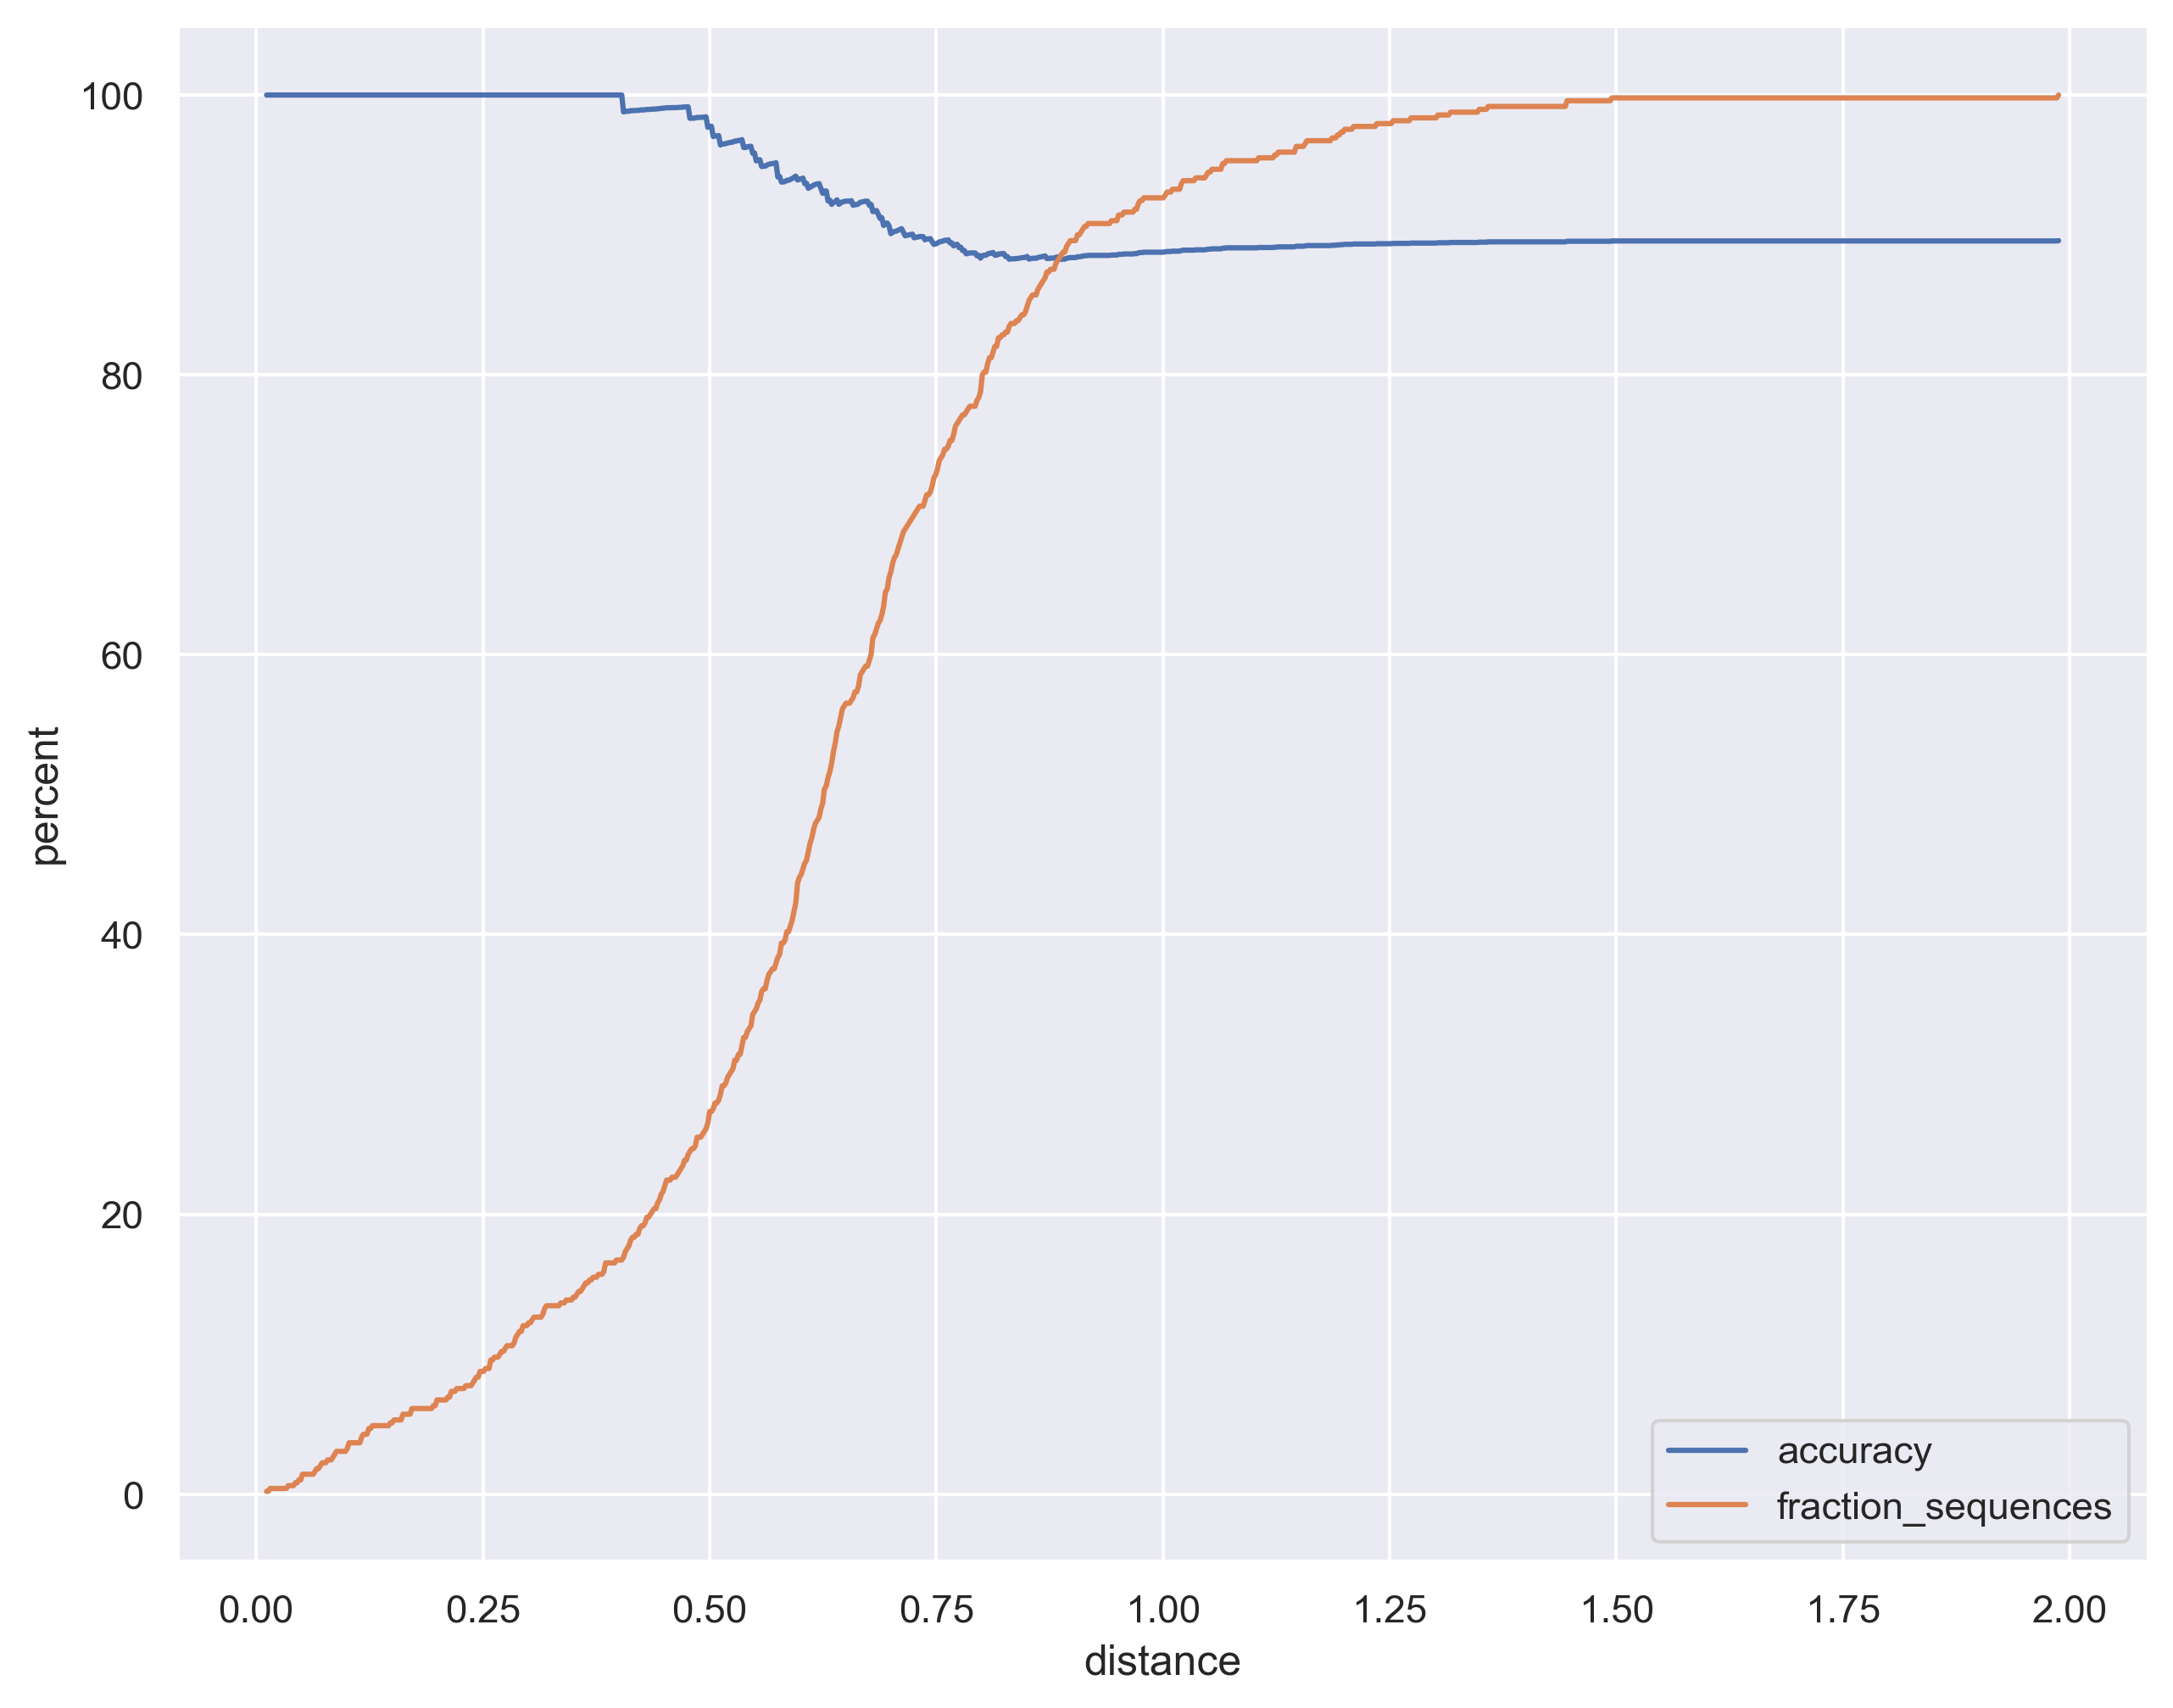

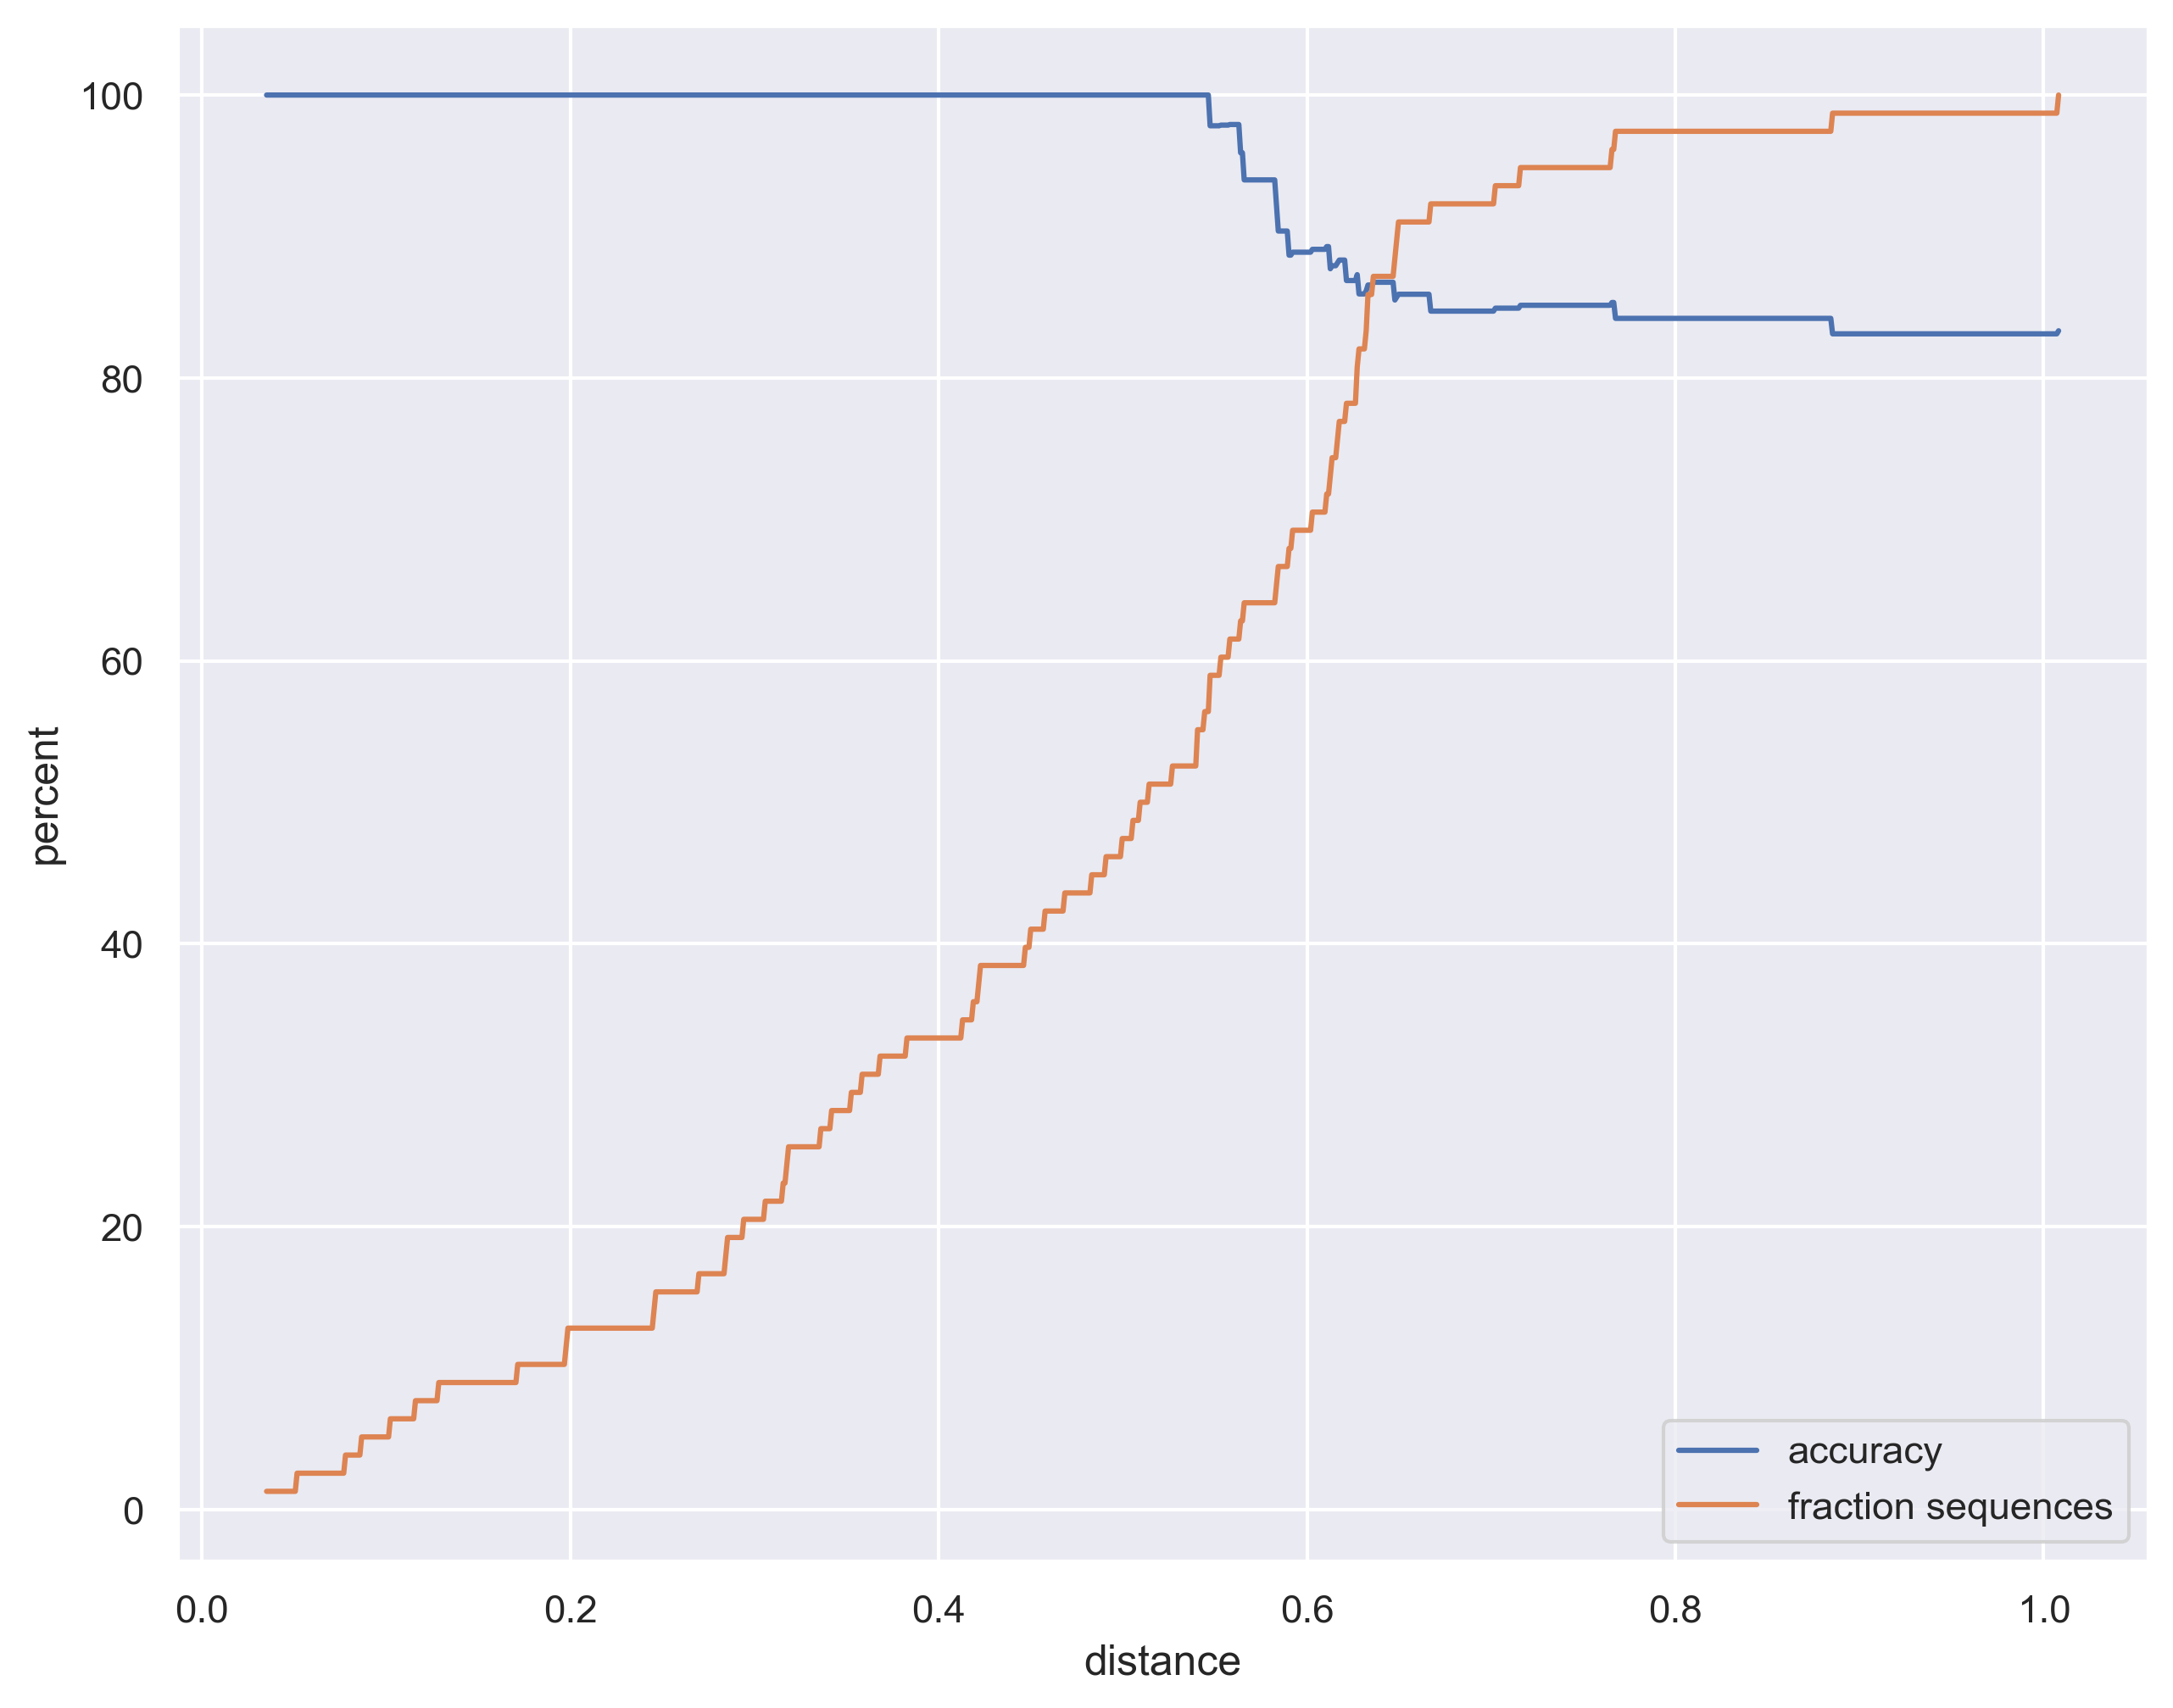

<Figure size 3000x2400 with 0 Axes>

In [34]:
plt.rcParams['figure.figsize'] = [10, 8]
df = pd.DataFrame(np.array([cutoffs,accuracies, percentage_sequences]).T,
                  columns=["distance", "accuracies", 'fraction sequences'])
df = df.melt('distance', var_name='cols',  value_name='percent')
sns.lineplot(x="distance", y="percent", hue='cols', data=df)
plt.legend(labels=['accuracy', 'fraction_sequences'])
plt.savefig('figure.png')
plt.show()
plt.clf()

df_ec = pd.DataFrame(np.array([cutoffs_ec,accuracies_ec,percentage_sequences_ec]).T,
                  columns=["distance", "accuracies", 'fraction sequences'])
df_ec = df_ec.melt('distance', var_name='cols',  value_name='percent')
sns.lineplot(x="distance", y="percent", hue='cols', data=df_ec)
plt.legend(labels=['accuracy', 'fraction sequences'])
plt.savefig('figure.png')
plt.show()
plt.clf()